# <center><b><font color='#0b5345'>N-beats</font></b></center>

## <font color='#196f3d'> Table of contents </font>

- [1 .Objectives](#1)
- [2. Setup](#2)
- [3. Helper Functions](#3) <br>
- [4. Loading and pre-processing data](#4) <br>
- [5. N-Beats](#5) <br>
    - [5.1. N-beats block Layer](#5.1) <br>
    - [5.2. Setting up hyperparameters](#5.2) <br>
    - [5.3. Building, compiling and training the model](#5.3) <br>
    - [5.4. Evaluation](#5.4) <br>
- [References](#references) <br>

<a name="1"></a>
## <b> <font color='#196f3d'> 1. Objectives </font> </b>

The objective of this notebook is to implement the methodology described in the n-BEATS paper, using Bitcoin price prediction as a case study. The notebook will focus on reproducing the key components of the n-BEATS model, applying it to a time-series dataset of Bitcoin prices, and evaluating its performance in forecasting future trends.

<a name="2"></a>
## <b> <font color='#196f3d'> 2. Setup </font> </b>

In [2]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import os,random
import pandas as pd
from datetime import datetime
from tensorflow.keras.utils import plot_model

In [29]:
tf.random.set_seed(42)

<a name="3"></a>
## <b> <font color='#196f3d'> 3. Helper Functions </font> </b>

In [48]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None 
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)



# make predictions
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data.
    """    
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions



# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)


  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}



# Make the train/test splits para nuestro dataset ventaneado
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    
    Recine arreglos de numpy
    Devuelve arreglos de numpy
    
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test: len(windows)=2780 aqu[i
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

# create windowed dataset
def create_windowed_dataset(dataset,window_size):
    """
    dataset: a dataset with a key "price"
    window size
    """
    # Make a copy of the Bitcoin historical data with block reward feature
    dataset_windowed = dataset.copy()
    # Add windowed columns
    for i in range(window_size): # shift values for each step in WINDOW_SIZE
        dataset_windowed[f"Price+{i+1}"] = dataset_windowed["Price"].shift(periods=i+1)
        
    
    # drop nan values
    dataset_windowed.dropna(inplace=True)
    
    # convert to float32
    #dataset_windowed["Price"] = dataset_windowed["Price"].astype(np.float32)
    
    dataset_windowed = dataset_windowed.astype(np.float32)

    # return
    return dataset_windowed

<a name="4"></a>
## <b> <font color='#196f3d'> 4. Loading and pre-processing data </font> </b>

In [6]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [7]:
# import data
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [8]:
# feature extraction
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


#### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance 

In [9]:
HORIZON = 1
WINDOW_SIZE = 7 

In [10]:
bitcoin_windowed = create_windowed_dataset(bitcoin_prices,WINDOW_SIZE)

In [11]:
# Create X (windows) and y (horizons) features
X = bitcoin_windowed.drop("Price", axis=1)
y = bitcoin_windowed["Price"]

In [12]:
X_train, X_test, y_train, y_test = make_train_test_splits(X.values, y.values)
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [13]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

<a name="5"></a>
## <b> <font color='#196f3d'> 5. N-beats </font> </b>

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

<a name="5.1"></a>
### <b> <font color='#17a589'> 5.1. N-beats block layer </font> </b>



IMAGE OF THE NET


In [28]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    """
    A custom N-BEATS block layer for time series forecasting.

    Args:
        input_size (int): Size of the input window.
        theta_size (int): Combined size of backcast (input_size) and forecast (horizon).
        horizon (int): Number of future time steps to predict.
        n_neurons (int): Number of neurons in each hidden layer.
        n_layers (int): Number of hidden layers.
    """

    def __init__(self, 
               input_size: int,
               theta_size: int, # will be window_size + horizon
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
            # the **kwargs argument takes care of all the arguments for the parent class 
                                    # (input_shape, trainable, name)
        super().__init__(**kwargs)
        assert theta_size == input_size + horizon, \
            "Theta size must be the sum of input_size and horizon."
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs):
        # Expect inputs of shape (batch_size, input_size)
        x = inputs  # Tensor shape: (batch_size, input_size)
        
        # x passes through each of the layer in self.hidden
        for layer in self.hidden:
            x = layer(x)
            
        # dense layer 
        theta = self.theta_layer(x) # 1 x (input_size + horizon)
        
        # Output the backcast and the forecast from theta
        # first "input size" values for backcast; last "horizon" values for forecast 
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [30]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [34]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model 
            # has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [35]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}\n")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [0.31746203 0.4051888  0.5235503  0.4375109  0.06986776 0.6349139
 0.4685326 ]

Forecast: 0.1956152766942978


<a name="5.2"></a>
### <b> <font color='#17a589'> 5.2. Setting up hyperparameters </font> </b>

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf 

In [37]:
# Values from N-BEATS paper
N_EPOCHS = 20 #5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30 

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

<a name="5.3"></a>
### <b> <font color='#17a589'> 5.3. Building, compiling and training the model </font> </b>

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks: 
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance) 

<img src='images/N-beatss.png'/>

!!!!!!!!!!! dibujo con explicacion mas detallada del codigo

In [42]:
def build_n_beats_model(NBeatsBlock, input_size=INPUT_SIZE, theta_size=THETA_SIZE, horizon=HORIZON,
                  n_neurons=N_NEURONS, n_layers=N_LAYERS, n_stacks=N_STACKS):
    
    # 1. Setup and instance of NBeatsBlock
    nbeats_block_layer = NBeatsBlock(input_size=input_size, 
                                     theta_size=theta_size,
                                     horizon=horizon,
                                     n_neurons=n_neurons,
                                     n_layers=n_layers,
                                     name="InitialBlock")

    # 2. Create input to stack
    stack_input = layers.Input(shape=(input_size), name="stack_input")

    # 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
    residuals, forecast = nbeats_block_layer(stack_input)

    # 4. Create stacks of block layers
    for i, _ in enumerate(range(n_stacks-1)): # first stack is already created in (3)

      # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
      backcast, block_forecast = NBeatsBlock(
          input_size=input_size,
          theta_size=theta_size,
          horizon=horizon,
          n_neurons=n_neurons,
          n_layers=n_layers,
          name=f"NBeatsBlock_{i}"
      )(residuals) # pass in the residuals

      # 6. Create the double residual stacking
      residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
      forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

    # 7. Put the stack model together
    model = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")
    
    return model


model = build_n_beats_model(NBeatsBlock)


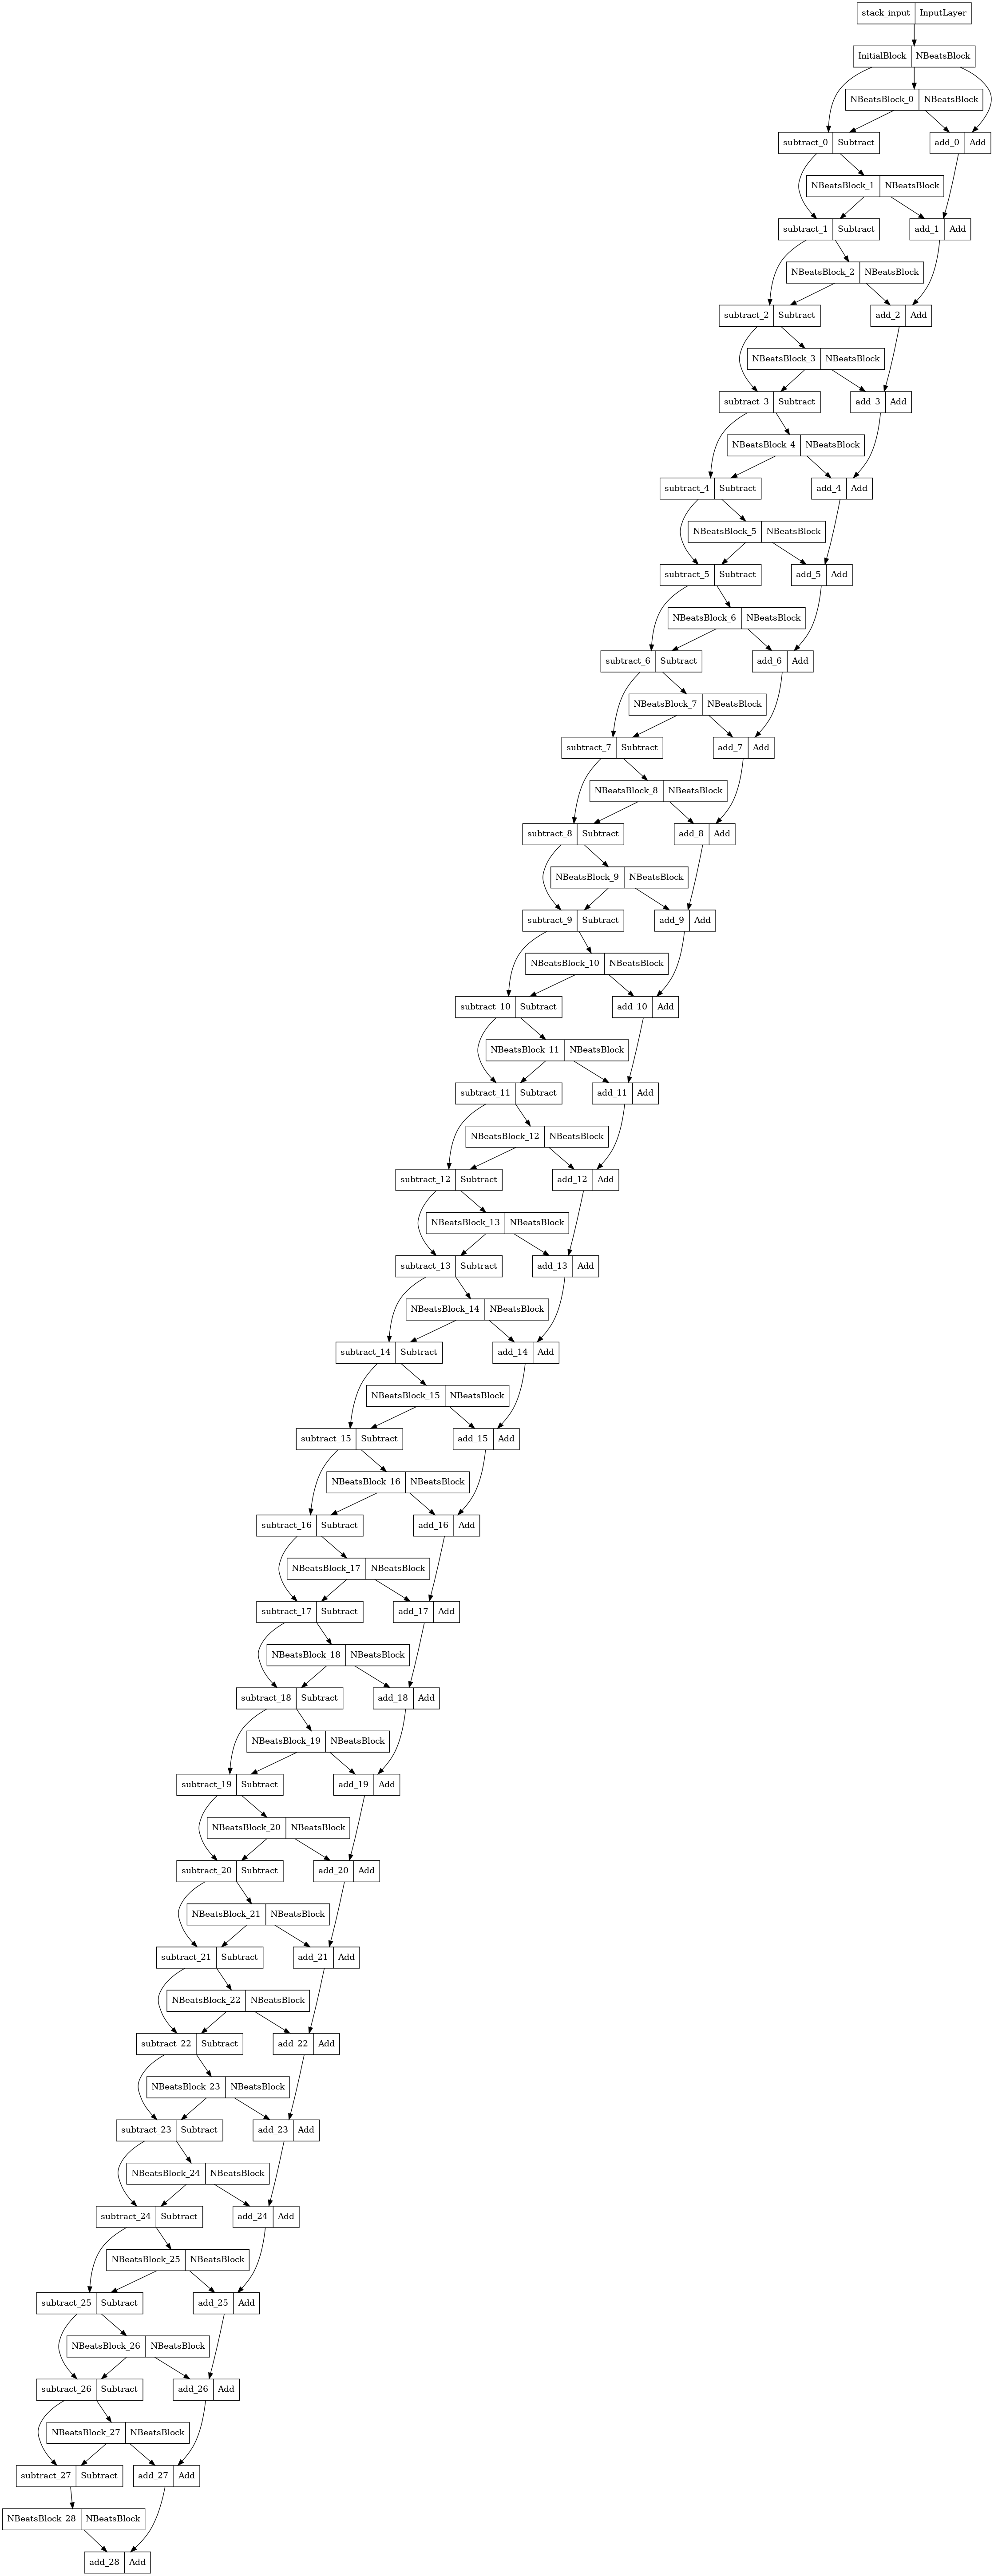

In [41]:
plot_model(model)

In [43]:
# 8. Compile model with MAE loss
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())



# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)]
           
           )

Epoch 1/20
3/3 [==============================] - 22s 1s/step - loss: 1633.8417 - val_loss: 17364.8965 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 2s 649ms/step - loss: 2306.1526 - val_loss: 82773.7266 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 2s 669ms/step - loss: 11748.5059 - val_loss: 10007.9912 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 2s 645ms/step - loss: 2091.7175 - val_loss: 11231.9678 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 2s 795ms/step - loss: 1377.5569 - val_loss: 5632.2651 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 3s 783ms/step - loss: 2597.6438 - val_loss: 5802.6733 - lr: 0.0010
Epoch 7/20
3/3 [==============================] - 3s 702ms/step - loss: 1846.1068 - val_loss: 10564.5293 - lr: 0.0010
Epoch 8/20
3/3 [==============================] - 3s 867ms/step - loss: 1604.3969 - val_loss: 5249.2817 - lr: 0.0010
Epoch 9/20
3/3 [==============================] - 2s 734ms/s

<a name="5.4"></a>
### <b> <font color='#17a589'> 5.4. Evaluation </font> </b>

In [44]:
# Evaluate N-BEats model on the test dataset
model.evaluate(test_dataset)

1/1 [==============================] - 0s 134ms/step - loss: 1009.6071


1009.6071166992188

In [46]:
# Make predictions with N-BEATS model
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9376.292, 9316.712, 9342.569, 9215.978, 9119.549, 9050.646,
       8982.015, 8909.428, 8871.384, 8811.02 ], dtype=float32)>

In [49]:
# Evaluate N-BEATS model preds
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 1009.6071, 'mse': 3427818.2, 'rmse': 1851.4368, 'mape': 4.6201}

## ANEXO

### Conexiones residuales

#### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://paperswithcode.com/method/resnet

In [20]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [33]:
#https://torres.ai/api-funcional-de-keras/

<a name="references"> </a>
## <font color='#196f3d'> <b> References </b> </font>

- [N-BEATS: Neural basis expansion analysis for interpretable time series forecasting](https://arxiv.org/pdf/1905.10437)


- [TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?srsltid=AfmBOoohjCA1pCbVFo0HwbHwZYekQjO07q3OBk2xaBEzql7K-lgqCTcc)